# Analysis of August 4th, 2021 Data for Cruising Method Performance

## Purpose:
To use the more up to date functions that make the analysis code cleaner, finding the overall aircraft performance.  (CL, CD)

## Methods:
Only cruising flight method is applicable to this flight, and even then it is not quite ideal.  

## Results:
To be saved, and taken with a grain of salt



In [1]:
### Definining name of analysis ###
name = '2021-08-04_Cruise_Analysis'
data_path = '../../data/'
data_folder = 'createv-2021-08-04'
file_name = 'august04_2021.BIN'

datasave_path = data_path+data_folder+'/'
result_path = '../Results/'+name+'/'
figure_path = '../Figures/'+name+'/'

## Importing Packages

In [2]:
from os import sys
import os
sys.path.append('../../')

%matplotlib widget

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

import main
from main import flight
from main import analysis
import propellers
import motors
from aircraft import airplane
import cl_finders

### Creating Folders for Results/Data ###
if not os.path.exists(result_path):
    os.makedirs(result_path)
if not os.path.exists(figure_path):
    os.makedirs(figure_path)
if not os.path.exists(data_path+data_folder):
    os.makedirs(data_path+data_folder)

# Setting Plot Defaults
plt.style.use('../../basic_plotter.mplstyle')

## Importing Data

In [3]:
# Importing data, specifying import characteristics, backing up results
rate = "10ms"
interpolateM = "linear"
processor = "CREATeV_2021b"

rawdata_name = data_folder+'/'+file_name.split('.')[0]+'_'+rate+'_'+interpolateM+'_'+processor+'.pkl'

# Checking if the data is already pickled for analysis
if os.path.exists(data_path+rawdata_name):
    df = pd.read_pickle(data_path+rawdata_name)
else:
    df = main.get_data(processor, data_path+data_folder+'/'+file_name, rate)
    df = df.interpolate(method=interpolateM)
    pd.to_pickle(df, data_path+rawdata_name) # Storing parsed data

## Defining Vehicle

In [4]:
# Vehicle parameters
prop = propellers.aeronaut20x8() # Using aeronaut 20x8 for this flight
motor = motors.U7V2_280KV()  # Using U7 V2 motor

mass = 12.6216 # Estimated with virtual bolt included
span = 6.28
chord = 0.395
createv = airplane(mass, chord, span)

## Manually Selecting Mask by Plots
Plots of airspeed, demanded airspeed; throttle output, and barometric altitude.  The strategy is to select data where there is little altitude change, little throttle variation, and wait for the airspeed to settle into a new demanded airspeed before using it.  

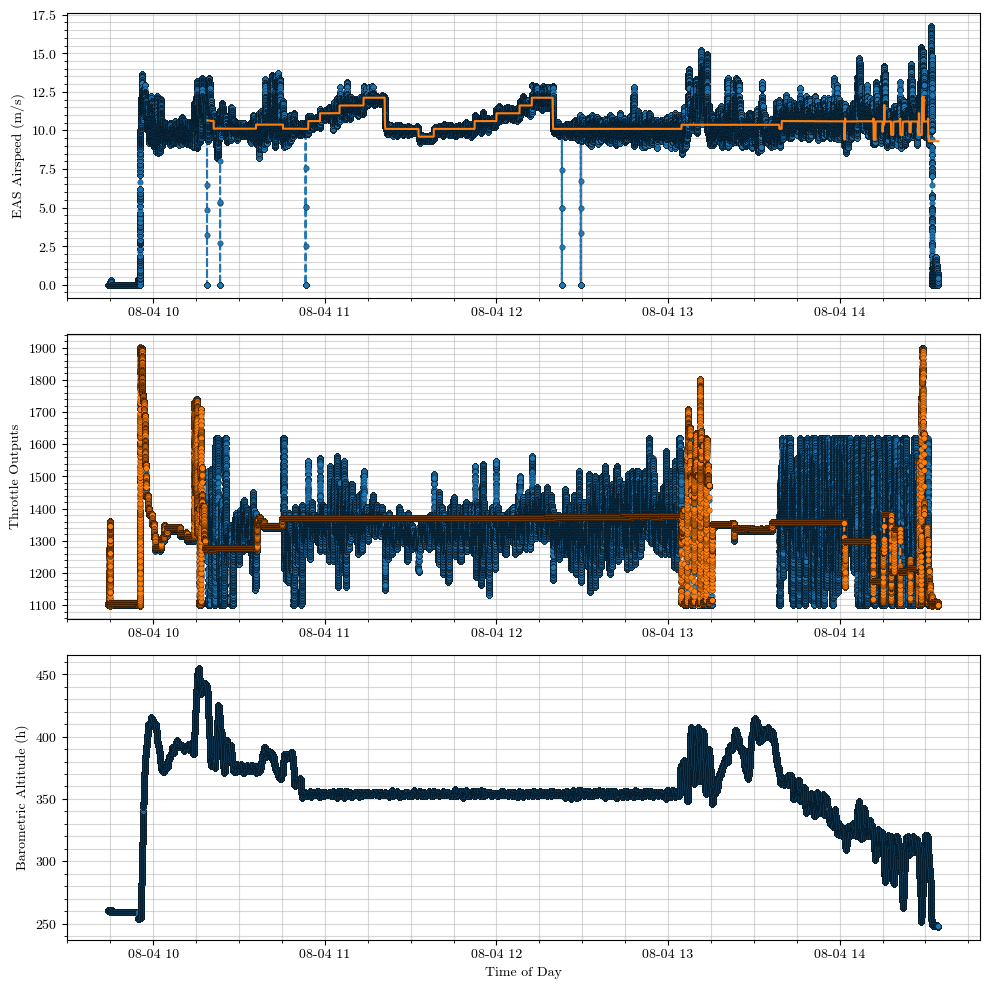

In [5]:
# Plotting Airspeed, Establishing Cruising Time Intervals
timeindex_v_thr_h = plt.figure(figsize=(10,10))

ax0 = plt.subplot(3,1,1)
plt.plot(df.index, df.Airspeed_Sensor0, linestyle='--', marker='o', markersize=4, markeredgecolor=[0,0,0])
# plt.plot(df.index, df.Airspeed_Sensor1, linestyle='--', marker='o', markersize=4, markeredgecolor=[0,0,0])
plt.plot(df.index, df.Airspeed_Demanded, linestyle='-', marker='', markersize=4, markeredgecolor=[0,0,0])

plt.ylabel("EAS Airspeed (m/s)")
ax1 = plt.subplot(3,1,2, sharex=ax0)
plt.grid("On")
plt.plot(df.index, df.ThrottleOut, linestyle='--', marker='o', markersize=4, markeredgecolor=[0,0,0])
plt.plot(df.index, df.Throttle, linestyle='--', marker='o', markersize=4, markeredgecolor=[0,0,0])
plt.ylabel("Throttle Outputs")
ax2 = plt.subplot(3,1,3, sharex=ax0)
plt.grid("On")
plt.plot(df.index, df.Altitude_GPS, linestyle='--', marker='o', markersize=4, markeredgecolor=[0,0,0])
plt.ylabel("Barometric Altitude (h)")
plt.xlabel("Time of Day")
plt.grid("On")
plt.show()

### Results of the Manual Segmentation

In [6]:
segtimes = np.array([['10:52:04','10:54:08'],
                      ['10:54:16','10:58:12'],
                      ['10:58:21','11:05:03'],
                      ['11:05:18','11:13:28'],
                      ['11:13:36','11:20:53'],
                      ['11:21:30','11:32:39'],
                      ['11:33:07','11:38:00'],
                      ['11:38:02','11:52:16'],
                      ['11:52:27','11:59:55'],
                      ['12:00:10','12:08:00'],
                      ['12:08:30','12:12:18'],
                      ['12:12:40','12:19:35']])
year = 2021
month = 8
day = 4

# Turning into a boolean mask list
masks = cl_finders.get_maskarray(df, segtimes, year, month, day)

#### Checking Segments for Good Data

Looking through the altitude, and flight path to see if they are good enough for the method.  IE constant altitude, and a loiter that is circular.  

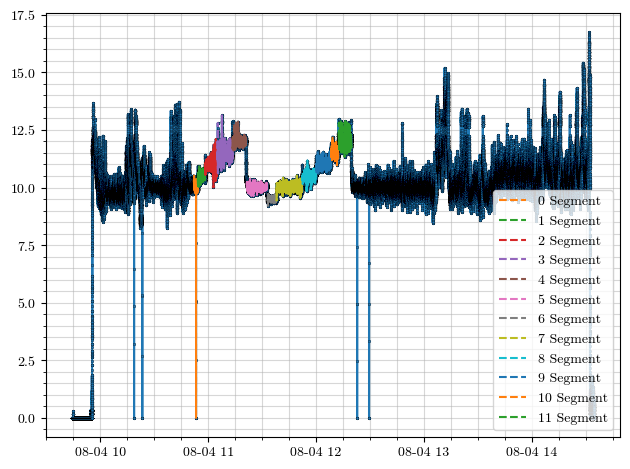

In [7]:
plt.figure()
plt.plot(df.index, df.Airspeed_Sensor0)
for i in np.arange(len(masks)):
    plt.plot(df.Airspeed_Sensor0[masks[i]], marker='', linestyle='--', label=str(i) + " Segment")
plt.legend()
plt.show()

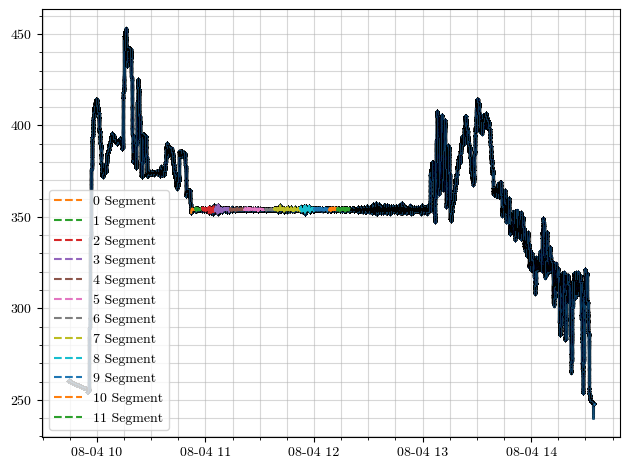

In [8]:
plt.figure()
plt.plot(df.index, df.Altitude_POS)
for i in np.arange(len(masks)):
    plt.plot(df.Altitude_POS[masks[i]], marker='', linestyle='--', label=str(i) + " Segment")
plt.legend()
plt.show()

Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.


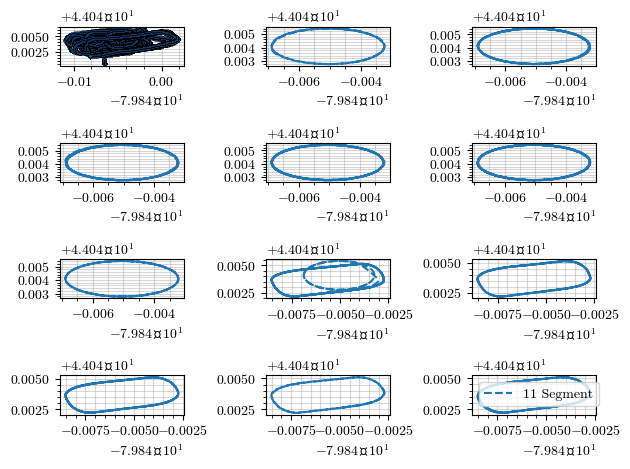

In [9]:
fig, axs = plt.subplots(4, 3)
axs = axs.flatten()
axs[0].plot(df.Longitude, df.Latitude)
for i in np.arange(1,12):
    axs[i].plot(df.Longitude[masks[i]], df.Latitude[masks[i]], marker='', linestyle='--', label=str(i) + " Segment")
plt.legend()
plt.show()

Notes on the selected intervals

* Intervals 1 to 6 are all circular ground tracks that are good for the airspeed calibration
* Intervals 6 to 11 are racetrack like loops, and should be fine for the performance assessment, making sure that the throttle demanded is still reasonably constant

In [10]:
segtimes = np.array([['10:52:04','10:54:08'],
                      ['10:54:16','10:58:12'],
                      ['10:58:21','11:05:03'],
                      ['11:05:18','11:13:28'],
                      ['11:13:36','11:20:53'],
                      ['11:21:30','11:32:39']])
year = 2021
month = 8
day = 4

# Turning into a boolean mask list
cruise_masks = cl_finders.get_maskarray(df, segtimes, year, month, day)

## Pre-Analysis Processing 
For fixing the fact that the airspeed read zero within the first interval.  I need to remove the zero from the dataset, using an interpolation or something.  

In [11]:
df.Airspeed_Sensor0.replace(0, np.NaN, inplace=True)
df.Airspeed_Sensor0.interpolate("linear", inplace=True)

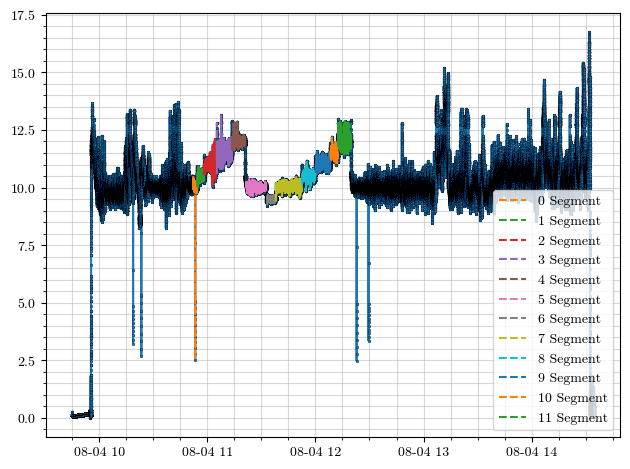

In [12]:
plt.figure()
plt.plot(df.index, df.Airspeed_Sensor0)
for i in np.arange(len(masks)):
    plt.plot(df.Airspeed_Sensor0[masks[i]], marker='', linestyle='--', label=str(i) + " Segment")
plt.legend()
plt.show()

## Performing Main Analysis Methods
Using all information in the dataframe, calculating the CL, CD for cruising eta and ct methods

In [13]:
############# Main Analysis ###############3

# Attitude 
phi = np.deg2rad(df["RollAngle"].to_numpy())            # Bank angle in radians

# Atmospheric adjustments:
rho = df["Pressure"].to_numpy() * (287 * (df["AmbientTemperature"].to_numpy()+273.15))**-1             # Density found from barometer pressure & airspeed sensor temperatures
v_eas = df["Airspeed_Sensor0"].to_numpy()                               # Equivalent SSL airspeed (m/s)
v_tas = v_eas * np.sqrt(1.225) * np.sqrt(rho)**-1   # the true airspeed
q = 0.5 * rho * v_tas**2                            # Dynamic pressure 

# Propulsion characterization
n = df["MotorRPM"].to_numpy() / 60                               # Revolutions per second
i_esc = df["EscCurrent"].to_numpy()
v_esc = df["EscVoltage"].to_numpy()
J = v_tas / (n * prop.diameter)
eff = prop.efficiency(J) * motor.efficiency(n, i_esc)

# Estimated propulsive power (New Fitting)
P_eta = cl_finders.eta_steady(prop, motor, v_tas, n, i_esc, v_esc)
P_ct = cl_finders.thrust_steady(prop, rho, v_tas, n)

# Getting drag coefficient
Cd_eta = cl_finders.preq2cd(createv, v_tas, q, P_eta)
Cd_ct = cl_finders.preq2cd(createv, v_tas, q, P_ct)

# Getting lift coefficient
CL = cl_finders.cl_banked(createv, q, phi)

/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_28262/2498797092.py:7: RuntimeWarning: invalid value encountered in reciprocal
  rho = df["Pressure"].to_numpy() * (287 * (df["AmbientTemperature"].to_numpy()+273.15))**-1             # Density found from barometer pressure & airspeed sensor temperatures
/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_28262/2498797092.py:9: RuntimeWarning: invalid value encountered in reciprocal
  v_tas = v_eas * np.sqrt(1.225) * np.sqrt(rho)**-1   # the true airspeed
/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_28262/2498797092.py:16: RuntimeWarning: divide by zero encountered in true_divide
  J = v_tas / (n * prop.diameter)
/Users/williamkemp/Records/Repositories/CREATeV_AnalysisSuite/Investigations/21_Cleaned_Performance_Analysis/../../propellers.py:39: RuntimeWarning: invalid value encountered in subtract
  CT = (0.1298*J**3) - 0.2679*J**2 - 0.02553*J + 0.07525
/Users/williamkemp/Records/Repositories/CREATeV_Analysi

## Collecting Data into Segments
Using the built function in cl_finders to collect the segments defined before.  
Doing some statistical analysis on them.  

### Collecting Averages and Standard Deviations from Segments
Going through the averages and standard deviations and 95% confidence intervals of each segment.  

In [14]:
[cl_means_eta, cl_stds_eta, cl_ci95s_eta, cd_means_eta, cd_stds_eta, cd_ci95s_eta] = cl_finders.collect_segments(masks, CL, Cd_eta)
[cl_means_ct, cl_stds_ct, cl_ci95s_ct, cd_means_ct, cd_stds_ct, cd_ci95s_ct] = cl_finders.collect_segments(masks, CL, Cd_ct)

### Collecting Total Datapoints from each of the Segments
Not averaging or processing, just raw CL, CD datapoints collected for display.  

In [15]:
# Totalling up CL, CD for Cruise
cl_total_cruise = cl_finders.total_segments_boolean(CL, masks)
cd_total_eta = cl_finders.total_segments_boolean(Cd_eta, masks)
cd_total_ct = cl_finders.total_segments_boolean(Cd_ct, masks)

## Collecting Data into Bins
Using bins for collection of the drag polar points.  

In [16]:
bins = np.linspace(0.05, 1.4, 51)
[cl_means_eta_bin, cl_stds_eta_bin, cl_ci95s_eta_bin, cd_means_eta_bin, cd_stds_eta_bin, cd_ci95s_eta_bin] = cl_finders.collect_bins(bins, cl_total_cruise, cd_total_eta)
[cl_means_ct_bin, cl_stds_ct_bin, cl_ci95s_ct_bin, cd_means_ct_bin, cd_stds_ct_bin, cd_ci95s_ct_bin] = cl_finders.collect_bins(bins, cl_total_cruise, cd_total_ct)

/Users/williamkemp/Records/Repositories/CREATeV_AnalysisSuite/Investigations/21_Cleaned_Performance_Analysis/../../cl_finders.py:385: RuntimeWarning: Mean of empty slice.
  cl_means = [total_lift_coeffs[digitized == i].mean() for i in range(1, len(bins))]
/Users/williamkemp/opt/anaconda3/envs/superwake-records/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/williamkemp/opt/anaconda3/envs/superwake-records/lib/python3.10/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/williamkemp/opt/anaconda3/envs/superwake-records/lib/python3.10/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/williamkemp/opt/anaconda3/envs/superwake-records/lib/python3.1

### Plotting the Results of the Bin and Segments

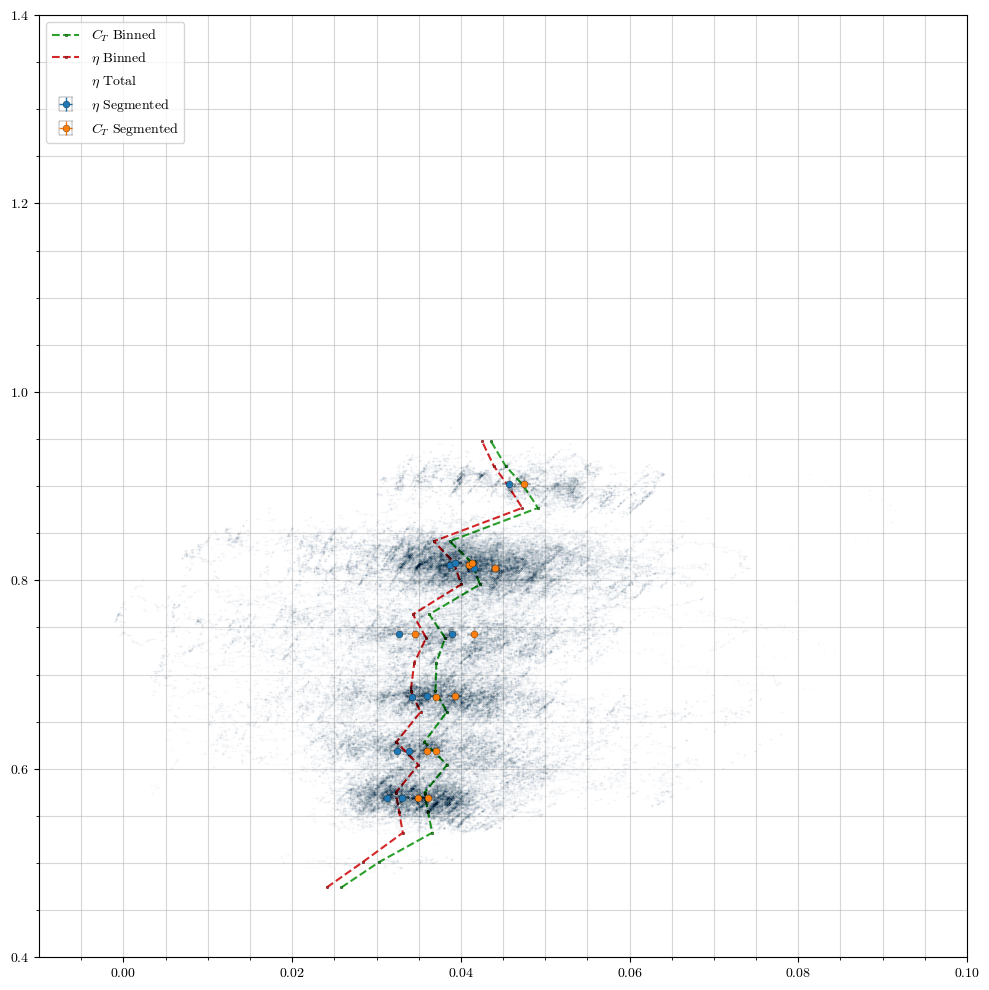

In [22]:
plt.figure(figsize=(10,10), dpi=100)
plt.errorbar(cd_means_eta, cl_means_eta, xerr=cd_ci95s_eta, yerr=cl_ci95s_eta, linestyle='', markersize = 10, capsize=5, elinewidth=1, label="$\eta$ Segmented")
plt.errorbar(cd_means_ct, cl_means_ct, xerr=cd_ci95s_ct, yerr=cl_ci95s_ct, linestyle='', markersize = 10, capsize=5, elinewidth=1, label="$C_T$ Segmented")
plt.plot(cd_means_ct_bin, cl_means_ct_bin, linestyle='--', label="$C_T$ Binned")
plt.plot(cd_means_eta_bin, cl_means_eta_bin, linestyle='--', label="$\eta$ Binned")

plt.plot(cd_total_ct, cl_total_cruise, linestyle='', color="C{}".format(0), alpha=0.01, marker='.', markersize=2, label="$\eta$ Total")
plt.xlim([-0.01, 0.1])
plt.ylim([0.4, 1.4])
plt.legend()
plt.show()

## Performing Curve Fit to Find the Polar

In [18]:
polar_eta = cl_finders.cd2polar(createv, cd_means_eta, cl_means_eta, highorder=False)
polar_ct = cl_finders.cd2polar(createv, cd_means_ct, cl_means_ct, highorder=False)

polar_eta_bin = cl_finders.cd2polar(createv, cd_means_eta_bin, cl_means_eta_bin, highorder=False)
polar_ct_bin = cl_finders.cd2polar(createv, cd_means_ct_bin, cl_means_ct_bin, highorder=False)

print(polar_eta)
print(polar_ct)

print(polar_eta_bin)
print(polar_ct_bin)

[0.02336554 0.79372927]
[0.02787973 0.92118134]
[0.02322422 0.81729405]
[0.0269581  0.91002077]


## Packaging the Results

In [19]:
eta_cruise_segresult = cl_finders.packaging_binresults(cl_total_cruise, cl_means_eta, cl_stds_eta, cl_ci95s_eta, cd_total_eta, cd_means_eta, cd_stds_eta, cd_ci95s_eta, polar_eta, createv)
ct_cruise_segresult = cl_finders.packaging_binresults(cl_total_cruise, cl_means_ct, cl_stds_ct, cl_ci95s_ct, cd_total_ct, cd_means_ct, cd_stds_ct, cd_ci95s_ct, polar_ct, createv)

eta_cruise_binresult = cl_finders.packaging_binresults(cl_total_cruise, cl_means_eta_bin, cl_stds_eta_bin, cl_ci95s_eta_bin, cd_total_eta, cd_means_eta_bin, cd_stds_eta_bin, cd_ci95s_eta_bin, polar_eta_bin, createv)
ct_cruise_binresult = cl_finders.packaging_binresults(cl_total_cruise, cl_means_ct_bin, cl_stds_ct_bin, cl_ci95s_ct_bin, cd_total_ct, cd_means_ct_bin, cd_stds_ct_bin, cd_ci95s_ct_bin, polar_ct_bin, createv)

## Saving the Results to Disk

In [20]:
# Saving results to their pickles
pd.to_pickle(eta_cruise_segresult, result_path+'eta_cruise_segresult.pkl')
pd.to_pickle(ct_cruise_segresult, result_path+'ct_cruise_segresult.pkl')

pd.to_pickle(eta_cruise_binresult, result_path+'eta_cruise_binresult.pkl')
pd.to_pickle(ct_cruise_binresult, result_path+'ct_cruise_binresult.pkl')